## **Import statements and set random seed**

In [1]:
# import time
import time
t1 = time.time()

In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import cv2
%matplotlib inline

In [3]:
# np_rand_seed = random.randint(0,100)
# tf_rand_seed = random.randint(0,100)
np_rand_seed = 88
tf_rand_seed = 33
np.random.seed(np_rand_seed)
# print("random seed of numpy: ", np_rand_seed)
# print("random seed of tensorflow: ", tf_rand_seed)

# **Loading training data**

**Load data**

In [4]:
# read the train data
train_data = pd.read_csv('../input/train.csv')

In [5]:
# print the shape of train data
print("shape of train_data:",train_data.shape)

shape of train_data: (42000, 785)


In [6]:
# display the head of data
train_data.head(10)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# RNN design parameters
n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10
n_layers = 3

**Feature engineer data**

In [8]:
# extract features and output 
features = train_data.columns.tolist()
output = "label"
features.remove(output)

In [9]:
# extract feature matrix
train_X = train_data[features].as_matrix()
train_X = train_X/255.0
# reshape the data into image
train_X = train_X.reshape((-1, n_steps, n_inputs))

In [10]:
# extract labels
train_y = train_data[output].as_matrix()
train_y = train_y.astype(int)
# one hot enncode the labels
train_y = pd.get_dummies(train_y).as_matrix()

In [11]:
print("shape of train_X:",train_X.shape)

shape of train_X: (42000, 28, 28)


In [12]:
print("shape of train_y:",train_y.shape)

shape of train_y: (42000, 10)


**Train validation split**

In [13]:
# generate training and validation indexes
train_indices = np.random.choice(len(train_y), round(len(train_y)*0.95), replace=False)
validation_indices = np.array(list(set(range(len(train_y))) - set(train_indices)))
# extract images for train and validation set
image_train = train_X[train_indices]
image_validation = train_X[validation_indices]
# extract labels for train and validation set
labels_train = train_y[train_indices]
labels_validation = train_y[validation_indices]

# **Augment Training set**

** Image Rotation**

In [14]:
def rotate_image(img, angle = 20):
    
    '''a function to rotate image by a given degree'''
    
    # rotate image
    copy = img.copy()

    M_rotate = cv2.getRotationMatrix2D((14,14),angle,1)
    img_new = cv2.warpAffine(copy,M_rotate,(28,28))

    return img_new

**Horizontal translation**

In [15]:
def translate_horizontal(image, shift_horizontal = 5):
    
    '''a function to translate image horizontally by a shift'''
    
    # horizontally shift image
    img = image.copy()
    
    shift_vertical = 0
    M_translate = np.float32([[1,0,shift_horizontal],[0,1,shift_vertical]])
    img_new = cv2.warpAffine(img,M_translate,(28,28))
    
    return img_new.reshape(28,28).astype(np.float32)

**Vertical translation**

In [16]:
def translate_vertical(image, shift_vertical = 5):
    
    '''a function to translate image vertically by a shift'''
    
    # vertically shift image
    img = image.copy()
    
    shift_horizontal = 0;
    if shift_vertical<0:
        image_slice = img[shift_vertical:,:].copy()
    if shift_vertical>0:
        image_slice = img[:shift_vertical,:].copy()
    M_translate = np.float32([[1,0,shift_horizontal],[0,1,shift_vertical]])
    img_new = cv2.warpAffine(img,M_translate,(28,28))
    
    return img_new.reshape(28,28).astype(np.float32)

**Translation along positive diagonal**

In [17]:
def translate_positive_diagonal(image, shift_diagonal = 5):
    
    '''a function to translate image along positive diagonal'''
    
    # translate image along positive diagonal
    img = image.copy()
    
    if shift_diagonal<0:
        hor_slice = img[shift_diagonal:,:].copy()
        ver_slice = img[:,shift_diagonal:].copy()
    else:
        hor_slice = img[:shift_diagonal,:].copy()
        ver_slice = img[:,:shift_diagonal].copy()
    M_translate = np.float32([[1,0,shift_diagonal],[0,1,shift_diagonal]])
    img_new = cv2.warpAffine(img,M_translate,(28,28))
    
    return img_new.reshape(28,28).astype(np.float32)

**Translation along negative diagonal**

In [18]:
def translate_negative_diagonal(image, shift_diagonal = 5):
    
    '''a function to translate image along negative diagonal'''
    
    # translate image along negative diagonal
    img = image.copy()
    
    if shift_diagonal<0:
        hor_slice = img[:-shift_diagonal,:].copy()
        ver_slice = img[:,shift_diagonal:].copy()
    if shift_diagonal>0:
        hor_slice = img[-shift_diagonal:,:].copy()
        ver_slice = img[:,:shift_diagonal].copy()
    M_translate = np.float32([[1,0,shift_diagonal],[0,1,-shift_diagonal]])
    img_new = cv2.warpAffine(img,M_translate,(28,28))
        
    return img_new.reshape(28,28).astype(np.float32)

**Zoom image**

In [19]:
def zoom(image, zoom_shift = 5):
    
    '''a function to zoom image'''
    
    # zoom image
    img = image.copy()
    
    # zoom in 
    if zoom_shift>0:
        # scale
        img_new = cv2.resize(img, (28+zoom_shift*2,28+zoom_shift*2)) 
        # crop
        img_new = img_new[zoom_shift:-zoom_shift,zoom_shift:-zoom_shift] 
    # zoom out
    else:
        zoom_shift *=-1        
        # scale
        img_new = cv2.resize(img, (28-zoom_shift*2,28-zoom_shift*2)) 
        # zero padding
        img_new = cv2.copyMakeBorder(img_new,zoom_shift,zoom_shift,zoom_shift,zoom_shift,
                                     cv2.BORDER_CONSTANT,value=0.0) 
        
    return img_new.reshape(28,28).astype(np.float32)

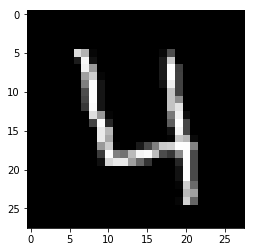

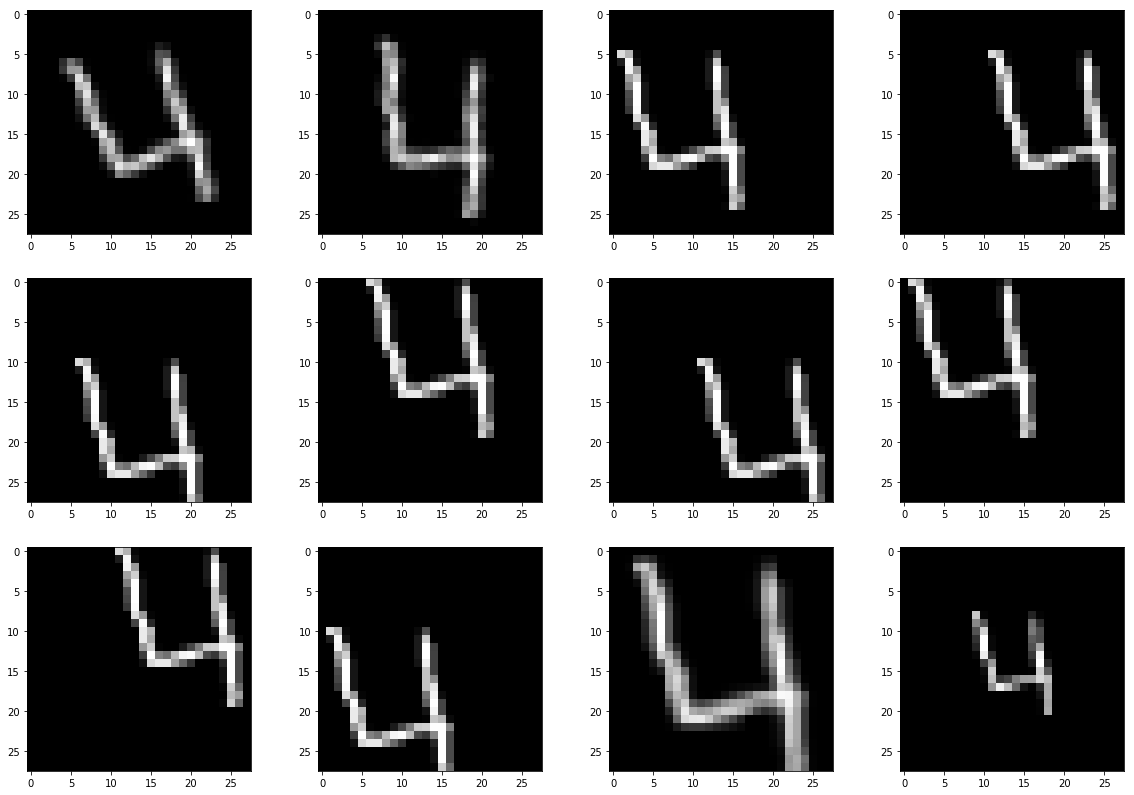

In [20]:
image = train_X[3]
plt.imshow(image, cmap='gray')
generated_image = rotate_image(image,10)
plt.show()
matplotlib.rcParams['figure.figsize'] = (20.0, 14.0)
plt.subplot(3,4,1)
plt.imshow(generated_image, cmap='gray')
generated_image = rotate_image(image,-10)
plt.subplot(3,4,2)
plt.imshow(generated_image, cmap='gray')
generated_image = translate_horizontal(image,-5)
plt.subplot(3,4,3)
plt.imshow(generated_image, cmap='gray')
generated_image = translate_horizontal(image,5)
plt.subplot(3,4,4)
plt.imshow(generated_image, cmap='gray')
generated_image = translate_vertical(image,5)
plt.subplot(3,4,5)
plt.imshow(generated_image, cmap='gray')
generated_image = translate_vertical(image,-5)
plt.subplot(3,4,6)
plt.imshow(generated_image, cmap='gray')
generated_image = translate_positive_diagonal(image,5)
plt.subplot(3,4,7)
plt.imshow(generated_image, cmap='gray')
generated_image = translate_positive_diagonal(image,-5)
plt.subplot(3,4,8)
plt.imshow(generated_image, cmap='gray')
generated_image = translate_negative_diagonal(image,5)
plt.subplot(3,4,9)
plt.imshow(generated_image, cmap='gray')
generated_image = translate_negative_diagonal(image,-5)
plt.subplot(3,4,10)
plt.imshow(generated_image, cmap='gray')
generated_image = zoom(image,5)
plt.subplot(3,4,11)
plt.imshow(generated_image, cmap='gray')
generated_image = zoom(image,-5)
plt.subplot(3,4,12)
plt.imshow(generated_image, cmap='gray')
plt.show()

In [21]:
def augment_data(image, labels):
    
    '''a function to augment band1 and band2 image'''
    
    # list to store the generated data
    image_generated = []
    labels_generated = []
    
    # iterate through each point in train set
    for i in range(labels.shape[0]):
        
        # rotate by positive degree
        angle = np.random.randint(1,6)
        image_generated.append(rotate_image(image[i],angle)) 
        labels_generated.append(labels[i])
        
        # rotate by negative degree
        angle = np.random.randint(1,6)
        image_generated.append(rotate_image(image[i],-angle)) 
        labels_generated.append(labels[i])
        
        # positive horizontal shift
        shift = np.random.randint(1,3)
        image_generated.append(translate_horizontal(image[i],+shift)) 
        labels_generated.append(labels[i])
        
        # negative horizontal shift
        shift = np.random.randint(1,3)
        image_generated.append(translate_horizontal(image[i],-shift)) 
        labels_generated.append(labels[i])
        
        # positive vertical shift
        shift = np.random.randint(1,3)
        image_generated.append(translate_vertical(image[i],+shift)) 
        labels_generated.append(labels[i])
        
        # negative vertical shift
        shift = np.random.randint(1,3)
        image_generated.append(translate_vertical(image[i],-shift)) 
        labels_generated.append(labels[i])
        
        # translate along positive diagonal in positive direction
        shift = np.random.randint(1,3)
        image_generated.append(translate_positive_diagonal(image[i],+shift)) 
        labels_generated.append(labels[i])
        
        # translate along positive diagonal in negative direction
        shift = np.random.randint(1,3)
        image_generated.append(translate_positive_diagonal(image[i],-shift)) 
        labels_generated.append(labels[i])
        
        # translate along negative diagonal in positive direction
        shift = np.random.randint(1,3)
        image_generated.append(translate_negative_diagonal(image[i],+shift)) 
        labels_generated.append(labels[i])
        
        # translate along negative diagonal in negative direction
        shift = np.random.randint(1,3)
        image_generated.append(translate_negative_diagonal(image[i],-shift)) 
        labels_generated.append(labels[i])
        
        # zoom in image
        zoom_shift = 2
        image_generated.append(zoom(image[i],zoom_shift)) 
        labels_generated.append(labels[i])
        
        # zoom out image
        zoom_shift = 2
        image_generated.append(zoom(image[i],-zoom_shift)) 
        labels_generated.append(labels[i])        
        
    # convert the generated data into numpy array
    image_generated = np.array(image_generated)
    labels_generated = np.array(labels_generated)
    
    # concatenate the generated data to original train set
    image_augmented = np.concatenate((image, image_generated),axis=0)
    labels_augmented = np.concatenate((labels, labels_generated),axis=0)
    
    return image_augmented, labels_augmented

In [22]:
image_train, labels_train = augment_data(image_train, labels_train)

In [23]:
print("Shape of image_train:",image_train.shape)
print("Shape of image_validation:",image_validation.shape)

Shape of image_train: (518700, 28, 28)
Shape of image_validation: (2100, 28, 28)


# **Create Recurrent Neural Network**

In [24]:
import tensorflow as tf
from tensorflow.python.framework import ops
ops.reset_default_graph()
# sess = tf.InteractiveSession()

In [25]:
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

In [26]:
lstm_cells = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
              for layer in range(n_layers)]

In [27]:
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

In [28]:
outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)
states

(LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_4:0' shape=(?, 150) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_5:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_6:0' shape=(?, 150) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_7:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_8:0' shape=(?, 150) dtype=float32>))

In [29]:
top_layer_h_state = states[-1][1]
top_layer_h_state

<tf.Tensor 'rnn/while/Exit_8:0' shape=(?, 150) dtype=float32>

In [30]:
logits = tf.layers.dense(top_layer_h_state, n_outputs, name="softmax")
logits

<tf.Tensor 'softmax/BiasAdd:0' shape=(?, 10) dtype=float32>

In [31]:
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

In [32]:
learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_step = optimizer.minimize(loss)

In [33]:
y_pred = tf.nn.softmax(logits)
y_pred_cls = tf.argmax(y_pred, axis=1, output_type=tf.int32)
y_true_cls = tf.argmax(y, axis=1, output_type=tf.int32)

In [34]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# **Train Model**

In [35]:
train_loss = []
valid_loss = []
valid_acc = []

train_batch_size = 250
max_iter = 1400

In [36]:
iteration = 0
best_accuracy = 0
best_iteration = 0
saver = tf.train.Saver(max_to_keep=1)

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())

    # while 59 minutes have not elapsed (to finish before the kernel is killed)
    while (time.time()-t1) < 58*60:
        
        # break if max iteration is reached
        if iteration >= max_iter:
            break

        rand_index_train = np.random.choice(labels_train.shape[0], size=train_batch_size)
        image_rand_train = image_train[rand_index_train]    
        labels_rand_train = labels_train[rand_index_train]

        feed_dict_batch =  {X: image_rand_train,
                            y: labels_rand_train}
        
#         feed_dict_train =  {X: image_rand_train,
#                             y: labels_rand_train}

        feed_dict_validation =  {X: image_validation,
                                 y: labels_validation}

        sess.run(train_step, feed_dict=feed_dict_batch)

        temp_train_loss = loss.eval(session=sess, feed_dict=feed_dict_batch)
        train_loss.append(temp_train_loss)

        temp_validation_loss = loss.eval(session=sess, feed_dict=feed_dict_validation)
        valid_loss.append(temp_validation_loss)

        temp_validation_accuracy = accuracy.eval(session=sess, feed_dict=feed_dict_validation)
        valid_acc.append(temp_validation_accuracy)   
        
        # if valid accuracy is better than best recorded so far then update the best valid accuracy
        if temp_validation_accuracy > best_accuracy:
            best_accuracy = temp_validation_accuracy
            best_iteration = iteration
            saver.save(sess, './my-model', global_step = best_iteration)
            
        print("iterations:",iteration,
              ", train_loss:",temp_train_loss,
              ", valid_loss:", temp_validation_loss,
              ", valid_accuracy:", temp_validation_accuracy)
        
        iteration += 1

iterations: 0 , train_loss: 0.644922 , valid_loss: 0.644879 , valid_accuracy: 0.105238
iterations: 1 , train_loss: 0.582365 , valid_loss: 0.580137 , valid_accuracy: 0.132857
iterations: 2 , train_loss: 0.477821 , valid_loss: 0.483544 , valid_accuracy: 0.100952
iterations: 3 , train_loss: 0.388362 , valid_loss: 0.387137 , valid_accuracy: 0.100952
iterations: 4 , train_loss: 0.337621 , valid_loss: 0.339781 , valid_accuracy: 0.100952
iterations: 5 , train_loss: 0.327798 , valid_loss: 0.331636 , valid_accuracy: 0.119524
iterations: 6 , train_loss: 0.328841 , valid_loss: 0.333199 , valid_accuracy: 0.0938095
iterations: 7 , train_loss: 0.332813 , valid_loss: 0.334147 , valid_accuracy: 0.0938095
iterations: 8 , train_loss: 0.331861 , valid_loss: 0.333933 , valid_accuracy: 0.09
iterations: 9 , train_loss: 0.331256 , valid_loss: 0.332997 , valid_accuracy: 0.09
iterations: 10 , train_loss: 0.331843 , valid_loss: 0.331841 , valid_accuracy: 0.09
iterations: 11 , train_loss: 0.328482 , valid_loss: 

iterations: 94 , train_loss: 0.287363 , valid_loss: 0.290073 , valid_accuracy: 0.222857
iterations: 95 , train_loss: 0.288857 , valid_loss: 0.28902 , valid_accuracy: 0.257619
iterations: 96 , train_loss: 0.289566 , valid_loss: 0.287859 , valid_accuracy: 0.292381
iterations: 97 , train_loss: 0.290434 , valid_loss: 0.285574 , valid_accuracy: 0.274286
iterations: 98 , train_loss: 0.285357 , valid_loss: 0.285582 , valid_accuracy: 0.265238
iterations: 99 , train_loss: 0.286043 , valid_loss: 0.284521 , valid_accuracy: 0.298095
iterations: 100 , train_loss: 0.286628 , valid_loss: 0.284354 , valid_accuracy: 0.290952
iterations: 101 , train_loss: 0.282134 , valid_loss: 0.282221 , valid_accuracy: 0.28
iterations: 102 , train_loss: 0.281207 , valid_loss: 0.284517 , valid_accuracy: 0.270476
iterations: 103 , train_loss: 0.284885 , valid_loss: 0.282172 , valid_accuracy: 0.277143
iterations: 104 , train_loss: 0.280925 , valid_loss: 0.279764 , valid_accuracy: 0.284286
iterations: 105 , train_loss: 0.

iterations: 187 , train_loss: 0.213348 , valid_loss: 0.195059 , valid_accuracy: 0.596667
iterations: 188 , train_loss: 0.194908 , valid_loss: 0.195215 , valid_accuracy: 0.593333
iterations: 189 , train_loss: 0.197291 , valid_loss: 0.191168 , valid_accuracy: 0.585238
iterations: 190 , train_loss: 0.195967 , valid_loss: 0.192291 , valid_accuracy: 0.555238
iterations: 191 , train_loss: 0.191467 , valid_loss: 0.190903 , valid_accuracy: 0.554286
iterations: 192 , train_loss: 0.184841 , valid_loss: 0.186447 , valid_accuracy: 0.578095
iterations: 193 , train_loss: 0.190907 , valid_loss: 0.189505 , valid_accuracy: 0.592381
iterations: 194 , train_loss: 0.18694 , valid_loss: 0.180419 , valid_accuracy: 0.61619
iterations: 195 , train_loss: 0.197029 , valid_loss: 0.197585 , valid_accuracy: 0.512381
iterations: 196 , train_loss: 0.176577 , valid_loss: 0.18995 , valid_accuracy: 0.554762
iterations: 197 , train_loss: 0.171495 , valid_loss: 0.180101 , valid_accuracy: 0.631905
iterations: 198 , train_

iterations: 280 , train_loss: 0.0987037 , valid_loss: 0.0939996 , valid_accuracy: 0.83619
iterations: 281 , train_loss: 0.0994571 , valid_loss: 0.102581 , valid_accuracy: 0.81619
iterations: 282 , train_loss: 0.0923751 , valid_loss: 0.0944177 , valid_accuracy: 0.83619
iterations: 283 , train_loss: 0.10186 , valid_loss: 0.0972756 , valid_accuracy: 0.83
iterations: 284 , train_loss: 0.117021 , valid_loss: 0.0925084 , valid_accuracy: 0.839048
iterations: 285 , train_loss: 0.110363 , valid_loss: 0.0960751 , valid_accuracy: 0.833333
iterations: 286 , train_loss: 0.107172 , valid_loss: 0.0965892 , valid_accuracy: 0.828095
iterations: 287 , train_loss: 0.090289 , valid_loss: 0.087427 , valid_accuracy: 0.851429
iterations: 288 , train_loss: 0.11965 , valid_loss: 0.109609 , valid_accuracy: 0.78381
iterations: 289 , train_loss: 0.117656 , valid_loss: 0.098556 , valid_accuracy: 0.81381
iterations: 290 , train_loss: 0.112302 , valid_loss: 0.0870741 , valid_accuracy: 0.85381
iterations: 291 , train

iterations: 371 , train_loss: 0.069549 , valid_loss: 0.0607823 , valid_accuracy: 0.900952
iterations: 372 , train_loss: 0.0647496 , valid_loss: 0.0579732 , valid_accuracy: 0.907143
iterations: 373 , train_loss: 0.0759839 , valid_loss: 0.0642569 , valid_accuracy: 0.888571
iterations: 374 , train_loss: 0.0822257 , valid_loss: 0.0636105 , valid_accuracy: 0.892381
iterations: 375 , train_loss: 0.0560701 , valid_loss: 0.0587118 , valid_accuracy: 0.908571
iterations: 376 , train_loss: 0.0598819 , valid_loss: 0.0626783 , valid_accuracy: 0.891429
iterations: 377 , train_loss: 0.0622963 , valid_loss: 0.0582381 , valid_accuracy: 0.906667
iterations: 378 , train_loss: 0.0568359 , valid_loss: 0.0563891 , valid_accuracy: 0.910476
iterations: 379 , train_loss: 0.0788349 , valid_loss: 0.0562849 , valid_accuracy: 0.911905
iterations: 380 , train_loss: 0.0644491 , valid_loss: 0.0561312 , valid_accuracy: 0.908095
iterations: 381 , train_loss: 0.0674577 , valid_loss: 0.05713 , valid_accuracy: 0.901905
it

iterations: 462 , train_loss: 0.0472359 , valid_loss: 0.0445509 , valid_accuracy: 0.927143
iterations: 463 , train_loss: 0.0573971 , valid_loss: 0.0450005 , valid_accuracy: 0.926667
iterations: 464 , train_loss: 0.058133 , valid_loss: 0.0542058 , valid_accuracy: 0.901905
iterations: 465 , train_loss: 0.0489341 , valid_loss: 0.0479449 , valid_accuracy: 0.917143
iterations: 466 , train_loss: 0.0455389 , valid_loss: 0.0392766 , valid_accuracy: 0.94
iterations: 467 , train_loss: 0.0363958 , valid_loss: 0.0446269 , valid_accuracy: 0.928095
iterations: 468 , train_loss: 0.0477504 , valid_loss: 0.0445633 , valid_accuracy: 0.92619
iterations: 469 , train_loss: 0.0351074 , valid_loss: 0.0407501 , valid_accuracy: 0.937619
iterations: 470 , train_loss: 0.0497995 , valid_loss: 0.0399987 , valid_accuracy: 0.938571
iterations: 471 , train_loss: 0.0407501 , valid_loss: 0.0441991 , valid_accuracy: 0.930952
iterations: 472 , train_loss: 0.054025 , valid_loss: 0.0448167 , valid_accuracy: 0.928095
iterat

iterations: 553 , train_loss: 0.0378594 , valid_loss: 0.0311174 , valid_accuracy: 0.956667
iterations: 554 , train_loss: 0.046057 , valid_loss: 0.0298047 , valid_accuracy: 0.95619
iterations: 555 , train_loss: 0.0340785 , valid_loss: 0.0292685 , valid_accuracy: 0.961429
iterations: 556 , train_loss: 0.0335297 , valid_loss: 0.0309545 , valid_accuracy: 0.954762
iterations: 557 , train_loss: 0.0373973 , valid_loss: 0.0340617 , valid_accuracy: 0.947619
iterations: 558 , train_loss: 0.0379663 , valid_loss: 0.0349087 , valid_accuracy: 0.945714
iterations: 559 , train_loss: 0.0337868 , valid_loss: 0.0304516 , valid_accuracy: 0.953333
iterations: 560 , train_loss: 0.025472 , valid_loss: 0.0315236 , valid_accuracy: 0.952857
iterations: 561 , train_loss: 0.0403816 , valid_loss: 0.0358818 , valid_accuracy: 0.942381
iterations: 562 , train_loss: 0.0415681 , valid_loss: 0.0375448 , valid_accuracy: 0.941905
iterations: 563 , train_loss: 0.0392233 , valid_loss: 0.0375202 , valid_accuracy: 0.940952
it

iterations: 644 , train_loss: 0.0444363 , valid_loss: 0.0316744 , valid_accuracy: 0.951905
iterations: 645 , train_loss: 0.0308842 , valid_loss: 0.0291907 , valid_accuracy: 0.95619
iterations: 646 , train_loss: 0.0246384 , valid_loss: 0.0268997 , valid_accuracy: 0.961429
iterations: 647 , train_loss: 0.0213074 , valid_loss: 0.0257434 , valid_accuracy: 0.963333
iterations: 648 , train_loss: 0.027234 , valid_loss: 0.0261708 , valid_accuracy: 0.962857
iterations: 649 , train_loss: 0.0236772 , valid_loss: 0.0273956 , valid_accuracy: 0.96
iterations: 650 , train_loss: 0.0366726 , valid_loss: 0.0282544 , valid_accuracy: 0.954762
iterations: 651 , train_loss: 0.0402089 , valid_loss: 0.0297282 , valid_accuracy: 0.952381
iterations: 652 , train_loss: 0.0439514 , valid_loss: 0.0286115 , valid_accuracy: 0.954286
iterations: 653 , train_loss: 0.02604 , valid_loss: 0.0252641 , valid_accuracy: 0.96381
iterations: 654 , train_loss: 0.0336438 , valid_loss: 0.0236417 , valid_accuracy: 0.965238
iteratio

iterations: 735 , train_loss: 0.0229732 , valid_loss: 0.0253554 , valid_accuracy: 0.959524
iterations: 736 , train_loss: 0.0253016 , valid_loss: 0.0234848 , valid_accuracy: 0.967619
iterations: 737 , train_loss: 0.0264924 , valid_loss: 0.0218892 , valid_accuracy: 0.967619
iterations: 738 , train_loss: 0.0234204 , valid_loss: 0.0244669 , valid_accuracy: 0.960952
iterations: 739 , train_loss: 0.0285292 , valid_loss: 0.0268629 , valid_accuracy: 0.953333
iterations: 740 , train_loss: 0.0311821 , valid_loss: 0.0245112 , valid_accuracy: 0.958095
iterations: 741 , train_loss: 0.0340008 , valid_loss: 0.0210198 , valid_accuracy: 0.968095
iterations: 742 , train_loss: 0.027808 , valid_loss: 0.0199229 , valid_accuracy: 0.971905
iterations: 743 , train_loss: 0.0239617 , valid_loss: 0.0210144 , valid_accuracy: 0.971429
iterations: 744 , train_loss: 0.030383 , valid_loss: 0.0238198 , valid_accuracy: 0.964286
iterations: 745 , train_loss: 0.0273029 , valid_loss: 0.0258099 , valid_accuracy: 0.958571
i

iterations: 826 , train_loss: 0.0231625 , valid_loss: 0.0242527 , valid_accuracy: 0.960952
iterations: 827 , train_loss: 0.0377578 , valid_loss: 0.0255043 , valid_accuracy: 0.958095
iterations: 828 , train_loss: 0.0276429 , valid_loss: 0.0254776 , valid_accuracy: 0.959048
iterations: 829 , train_loss: 0.0259183 , valid_loss: 0.0235987 , valid_accuracy: 0.961429
iterations: 830 , train_loss: 0.0146516 , valid_loss: 0.0212692 , valid_accuracy: 0.965238
iterations: 831 , train_loss: 0.0309087 , valid_loss: 0.0189954 , valid_accuracy: 0.973333
iterations: 832 , train_loss: 0.0213353 , valid_loss: 0.0191198 , valid_accuracy: 0.97
iterations: 833 , train_loss: 0.0221225 , valid_loss: 0.0194844 , valid_accuracy: 0.968571
iterations: 834 , train_loss: 0.0207271 , valid_loss: 0.0188541 , valid_accuracy: 0.970952
iterations: 835 , train_loss: 0.0190462 , valid_loss: 0.0187432 , valid_accuracy: 0.972857
iterations: 836 , train_loss: 0.0236914 , valid_loss: 0.0185896 , valid_accuracy: 0.971429
ite

iterations: 917 , train_loss: 0.0217882 , valid_loss: 0.018602 , valid_accuracy: 0.971905
iterations: 918 , train_loss: 0.0140279 , valid_loss: 0.0193772 , valid_accuracy: 0.972381
iterations: 919 , train_loss: 0.0284154 , valid_loss: 0.0191446 , valid_accuracy: 0.971429
iterations: 920 , train_loss: 0.0141577 , valid_loss: 0.0190034 , valid_accuracy: 0.973333
iterations: 921 , train_loss: 0.0236318 , valid_loss: 0.0193898 , valid_accuracy: 0.972381
iterations: 922 , train_loss: 0.0179068 , valid_loss: 0.0197045 , valid_accuracy: 0.970952
iterations: 923 , train_loss: 0.0232581 , valid_loss: 0.0203014 , valid_accuracy: 0.970476
iterations: 924 , train_loss: 0.0267061 , valid_loss: 0.0210822 , valid_accuracy: 0.968571
iterations: 925 , train_loss: 0.0194535 , valid_loss: 0.0210226 , valid_accuracy: 0.969524
iterations: 926 , train_loss: 0.0188838 , valid_loss: 0.0206922 , valid_accuracy: 0.969048
iterations: 927 , train_loss: 0.0193587 , valid_loss: 0.0196485 , valid_accuracy: 0.972381


iterations: 1008 , train_loss: 0.0173973 , valid_loss: 0.0190957 , valid_accuracy: 0.972381
iterations: 1009 , train_loss: 0.0191854 , valid_loss: 0.0185745 , valid_accuracy: 0.973333
iterations: 1010 , train_loss: 0.017055 , valid_loss: 0.0184163 , valid_accuracy: 0.97381
iterations: 1011 , train_loss: 0.0173452 , valid_loss: 0.0185305 , valid_accuracy: 0.973333
iterations: 1012 , train_loss: 0.0241114 , valid_loss: 0.0179141 , valid_accuracy: 0.974286
iterations: 1013 , train_loss: 0.0244866 , valid_loss: 0.0169851 , valid_accuracy: 0.97619
iterations: 1014 , train_loss: 0.01334 , valid_loss: 0.0158372 , valid_accuracy: 0.976667
iterations: 1015 , train_loss: 0.0185583 , valid_loss: 0.0142683 , valid_accuracy: 0.978571
iterations: 1016 , train_loss: 0.0186543 , valid_loss: 0.0140306 , valid_accuracy: 0.978095
iterations: 1017 , train_loss: 0.0178697 , valid_loss: 0.015344 , valid_accuracy: 0.977143
iterations: 1018 , train_loss: 0.0213807 , valid_loss: 0.0170173 , valid_accuracy: 0.9

iterations: 1098 , train_loss: 0.010272 , valid_loss: 0.0176948 , valid_accuracy: 0.972857
iterations: 1099 , train_loss: 0.00767316 , valid_loss: 0.0179562 , valid_accuracy: 0.972381
iterations: 1100 , train_loss: 0.017358 , valid_loss: 0.0175797 , valid_accuracy: 0.973333
iterations: 1101 , train_loss: 0.0124513 , valid_loss: 0.0171139 , valid_accuracy: 0.974762
iterations: 1102 , train_loss: 0.0168715 , valid_loss: 0.0165542 , valid_accuracy: 0.97619
iterations: 1103 , train_loss: 0.0231552 , valid_loss: 0.0157719 , valid_accuracy: 0.97619
iterations: 1104 , train_loss: 0.0168507 , valid_loss: 0.0153646 , valid_accuracy: 0.975714
iterations: 1105 , train_loss: 0.0129196 , valid_loss: 0.0152307 , valid_accuracy: 0.977619


In [37]:
print("Best accuracy is",best_accuracy,"attained at iteration", best_iteration)

Best accuracy is 0.981905 attained at iteration 1027


In [38]:
del(train_data,train_X,train_y,image_train, image_validation, labels_train, labels_validation)

# **Create submission file**

In [39]:
test_data = pd.read_csv('../input/test.csv')
test_X = test_data[features].as_matrix()
test_X = test_X.reshape((-1, n_steps, n_inputs))
iD = test_data.index.tolist()
print(test_X.shape)
del(test_data)

(28000, 28, 28)


In [40]:
with tf.Session() as sess:    
    
    # restore the best model
    model_path = "./"+"my-model-"+str(best_iteration)
    saver.restore(sess, model_path)
    
    # break the test set into k folds other wise kernel will be out of memory
    n = test_X.shape[0]
    k = 10
    step = n//k
    
    # array to store the prediction
    preds = np.array([])

    # iterate through each fold
    for i in range(k):

        # start and end indices of the fold
        start = (step*i)
        end = (step*(i+1)) 
    
        # feed dictionary for the fold
        feed_dict_test =  {X: test_X[start:end]}

        # evaluate predictions of the fold
        fold_preds = y_pred_cls.eval(session=sess, feed_dict = feed_dict_test)
        
        # append the predictions of the fold to the designated array
        preds = np.append(preds, fold_preds)
        
        print("Finished computing prediction for fold", i)
        
    preds = preds.astype(np.int)
    
    # save the submission csv file
    submission_path = "./submission.csv"
    submission = pd.DataFrame({"ImageId": iD, "Label": preds})
    submission.to_csv(submission_path, header = True, index=False)

INFO:tensorflow:Restoring parameters from ./my-model-1027
Finished computing prediction for fold 0
Finished computing prediction for fold 1
Finished computing prediction for fold 2
Finished computing prediction for fold 3
Finished computing prediction for fold 4
Finished computing prediction for fold 5
Finished computing prediction for fold 6
Finished computing prediction for fold 7
Finished computing prediction for fold 8
Finished computing prediction for fold 9


# **Visualize Performance**

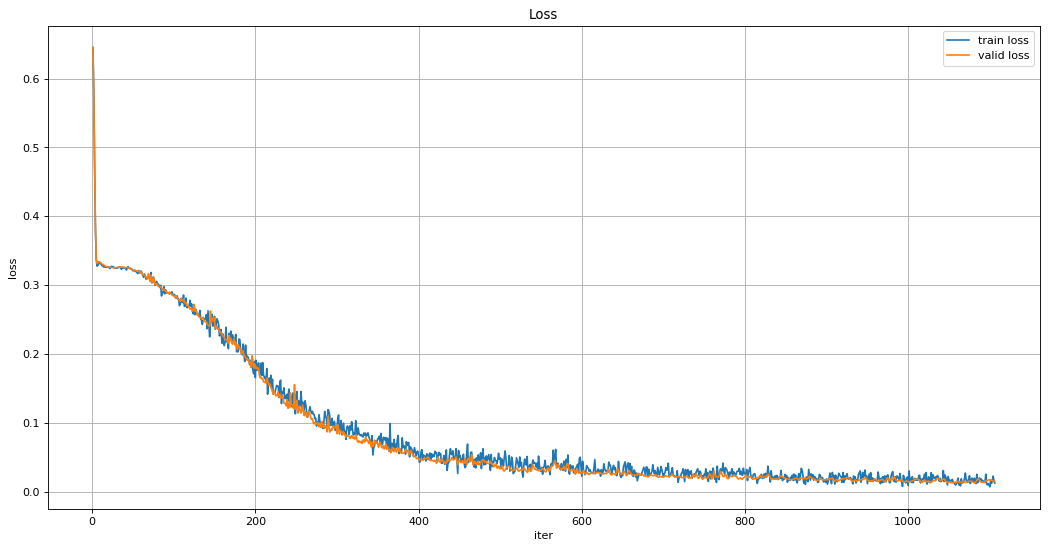

In [41]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
iterations = list(range(1,iteration+1))
plt.plot(iterations, train_loss, label = "train loss")
plt.plot(iterations, valid_loss, label = "valid loss")
plt.title("Loss")
plt.xlabel("iter")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.show()

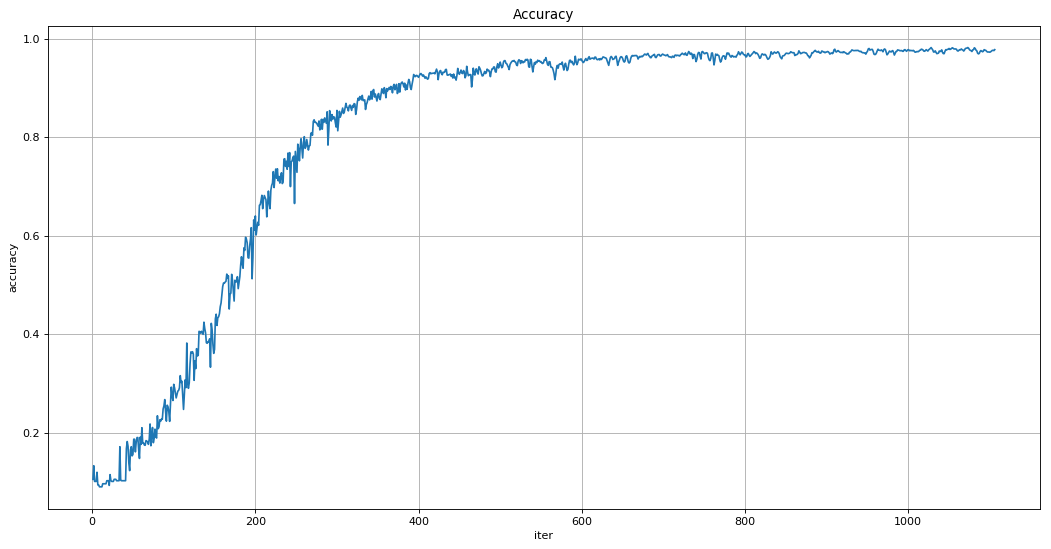

In [42]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(iterations, valid_acc, label = "train loss")
plt.title("Accuracy")
plt.xlabel("iter")
plt.ylabel("accuracy")
plt.grid()
plt.show()